# Visualise halo distributions

This notebook showcases how you can use the test bench to visualise a given halo catalog, namely we will look at the halo number distributions across different gridding resolutions and mass bins. The test bench will do the heavy lifting of reading in the catalogues and process the catalogues in an automated fashion.

In [11]:
import bias_bench as bb

import numpy as np
import pandas as pd
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [9]:
def convert_dataframe_catalog_to_numpy(dataframe_cat):
    numpy_halo_cat = np.empty(dataframe_cat.index.size,
                              dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('mvir', '<f8')])

    numpy_halo_cat['x'] = dataframe_cat.values.T[0]
    numpy_halo_cat['y'] = dataframe_cat.values.T[1]
    numpy_halo_cat['z'] = dataframe_cat.values.T[2]
    numpy_halo_cat['mvir'] = dataframe_cat.values.T[3]

    return numpy_halo_cat

In [2]:
# Specify the simulation properties
box_size = 500
mass_threshold = 5e11
n_cats = 2
# cat_paths = [f'/data80/sding/quijote/{cat_i}/rockstar/out_4_pid.list' for cat_i in range(n_cats)]
cat_paths = [f'/data80/sding/npe_paper/gadget/high_res_z0/mesh_64/halos_{i}.ascii' for i in range(2)]

In [3]:
# Binning settings for mass and resolution
# mass_bins = np.array([5.e+13, 7.e+13, 1.e+14, 5.e+14, 1.e+15])
mass_bins = np.array([5.e+11, 1.e+12, 5.e+12, 1.e+13, 5.e+13, 1.e+14, 1.e+15])
mesh_sizes = np.array([8, 16, 32, 64, 128])

mass_lo_hi = ['{:.0e}'.format(n).split('e+') for n in mass_bins]

In [4]:
cats = bb.read_rockstar_ascii_cat(cat_paths, mass_threshold, capital_id=False, convert_to_numpy=True)

KeyError: 'mvir'

In [10]:
# Cell for processing gadget catalogues
test = pd.read_csv(cat_paths[0], sep=' ', comment='#', header=0)
reduced_cat = test.loc[test['mvir'] >= mass_threshold, ['x', 'y', 'z', 'mvir']]
reduced_cat = convert_dataframe_catalog_to_numpy(reduced_cat)
cats = [reduced_cat]

In [12]:
coords_per_mass_bin = bb.get_halo_coords_per_mass_bin(mass_bins, cats[0])
halo_count_fields_per_mesh_size_and_mass_bin = [np.array([bb.get_halo_count_field(coords_per_mass_bin[mass_bin_id], mesh_sizes[mesh_size_id]) for
                                  mass_bin_id in range(mass_bins.size - 1)]) for mesh_size_id in range(mesh_sizes.size)] 

In [19]:
save_dir = "/data80/sding/halo_dist_paper/"
for mesh_i in range(len(mesh_sizes)):
    np.save(save_dir + f'halo_count_fields_mesh_{mesh_sizes[mesh_i]}.npy', halo_count_fields_per_mesh_size_and_mass_bin[mesh_i])

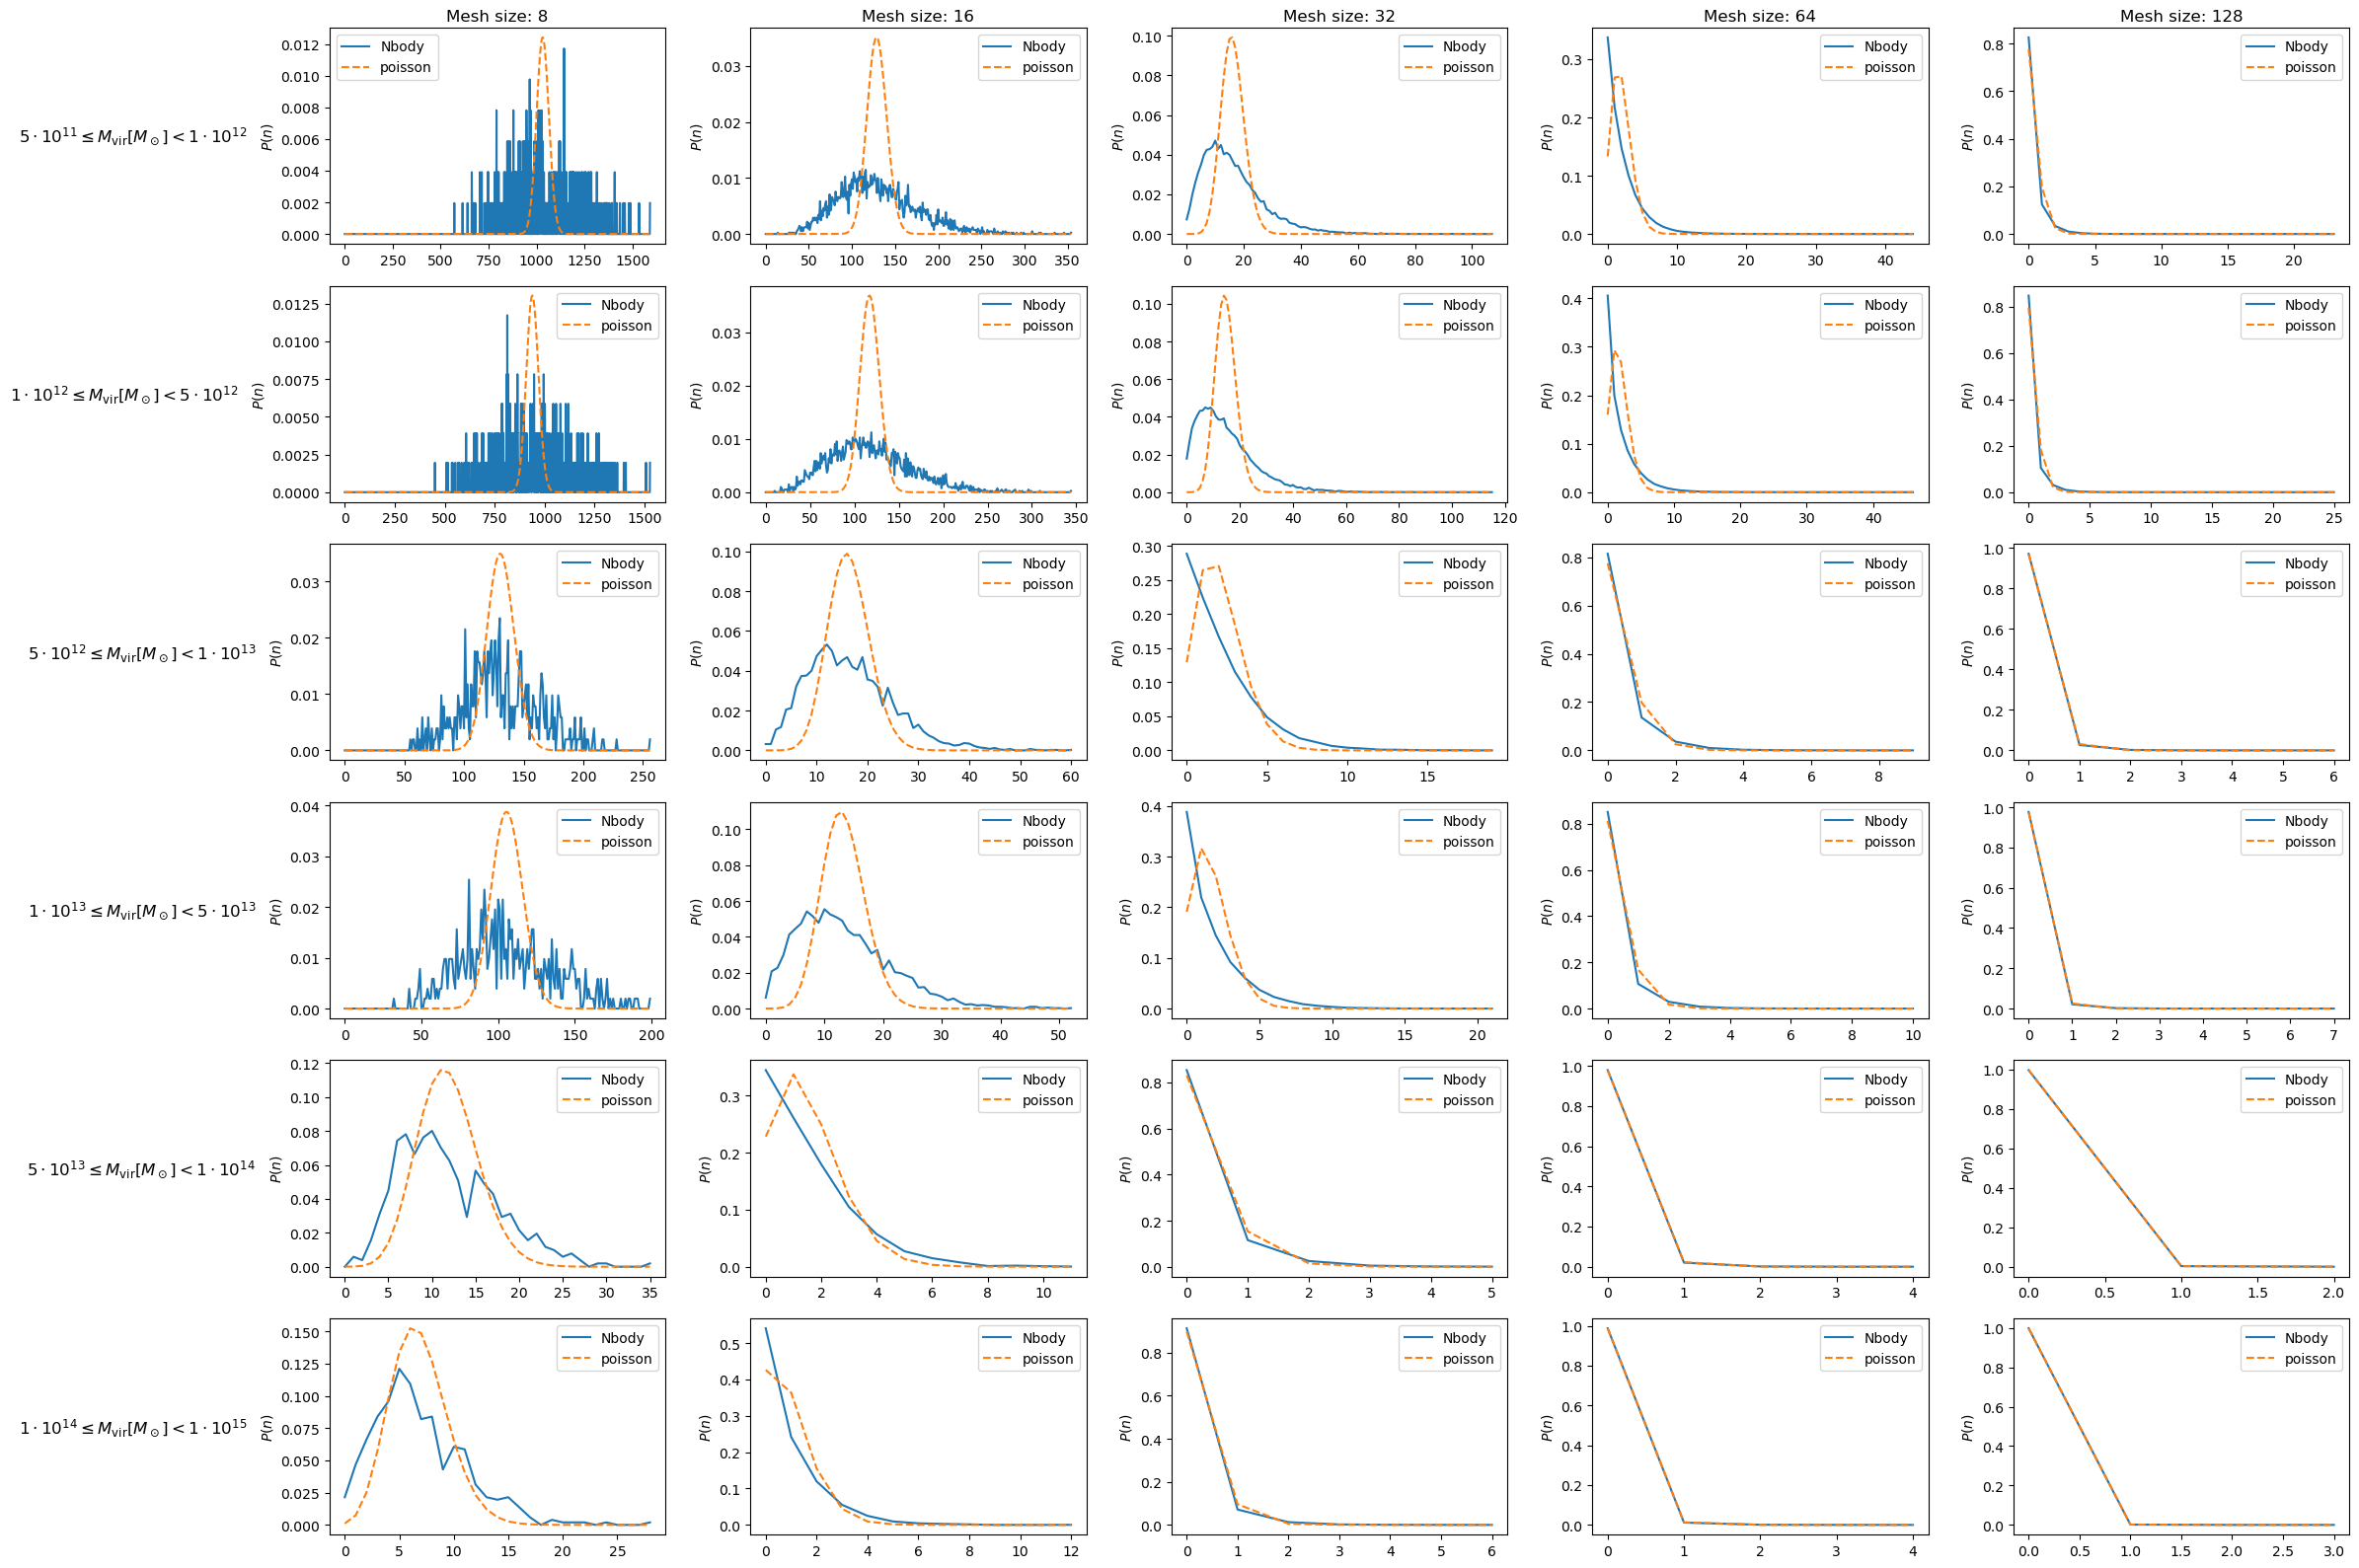

In [86]:
row_titles = []

for i in range(len(mass_bins) - 1):
    m_hi = mass_lo_hi[i+1]
    m_lo = mass_lo_hi[i]

    m_lo_str = m_lo[0] + r"\cdot 10^{" + m_lo[1] + '}'
    try:
        m_hi_str = '<' + m_hi[0] + r"\cdot 10^{" + m_hi[1] + '}'
    except IndexError:
        m_hi_str = ""
            
    row_titles.append('$' + m_lo_str + r"\leq M_{\mathrm{vir}} [M_\odot]" + m_hi_str + '$')

column_titles = [f'Mesh size: {mesh_sizes[i]}' for i in range(len(mesh_sizes))]

fig, axs = plt.subplots(nrows=len(mass_bins)-1, ncols=len(mesh_sizes), figsize=(24, 16))
for j in range(len(mesh_sizes)):
    for i in range(len(mass_bins)-1):

        max_count = halo_count_fields_per_mesh_size_and_mass_bin[j][i].max()

        hist, bins = np.histogram(halo_count_fields_per_mesh_size_and_mass_bin[j][i].flatten(), np.arange(0, max_count+2), density=True)
        poisson_pred = poisson.pmf(bins[:-1], halo_count_fields_per_mesh_size_and_mass_bin[j][i].mean())
        # print(f"predicted mean: {halo_number_per_mass_bin_per_voxel[i].mean()}")
        axs[i][j].plot(bins[:-1], hist, label='Nbody')
        axs[i][j].plot(bins[:-1], poisson_pred , ls='--', label='poisson')
        axs[i][j].set_ylabel(r"$P(n)$")

        # ax[1].plot(bins[:-1], poisson_pred/hist - 1)
        # ax[1].set_ylabel("$P_{pred}/P_{sim} -1$")
        axs[i][j].legend()
        # axs[i][j].set_title('$' + m_lo_str + r"\leq M_{\mathrm{vir}} [M_\odot]" + m_hi_str + '$' + f' | ms {mesh_size}')
        # fig.savefig(f"/data80/sding/npe_paper/gadget/high_res_z0/mesh_64/halo_dist_8mpc_mass_bin_{i}.svg", format='svg', dpi=300)
        
        
pad = 5 # in points

for ax, col in zip(axs[0], column_titles):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], row_titles):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.savefig("/data80/sding/halo_dist_paper/halo_dist_high_res_gadget.png", dpi=300)
plt.show()